In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./datasets/tutorial_sleep_training_data.csv.gz")
df = df.dropna().reset_index(drop=True) # Remove HR nan values

# Non-ML State of the Art

## Traditional algorithms:

### Webster (1982)
https://academic.oup.com/sleep/article/5/4/389/2753301

### Cole-Kripke Algorithm (1992)
https://pubmed.ncbi.nlm.nih.gov/1455130/

### Sadeh algorithm (1994)
https://pubmed.ncbi.nlm.nih.gov/7939118/

### +20 years of optimizing/validating formulas with various datasets:
- #### Oakley (1997) (Technical Report)
- #### Saznov (2004) (https://iopscience.iop.org/article/10.1088/0967-3334/25/5/018)
- #### Scripps Clinic (2010) (https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1365-2869.2010.00835.x/)


### ~2009 start of ML for sleep/wake classification
E.g. Tilmanne, J. et al (2009) (https://pubmed.ncbi.nlm.nih.gov/19250177/)
        

---
#### The Cole-Kripke formula:
<img src="images/cole-kripke.png" width="400" height="200">


## Outcomes:
$
\begin{cases}
\color{blue}{D < 1}  &\color{blue}{\rightarrow \text{Sleep}} \\
\color{red}{D \geq 1} &\color{red}{\rightarrow \text{Wake}}
\end{cases}
$

<img src="images/timewindows_colekripke.png" width="600" height="200">

### What do you think about this algorithm?
---


In [3]:
def cole_kripke_algorithm(activity: pd.Series) -> pd.Series:
    """
    Cole-Kripke method to classify sleep vs awake
    """
    act_series = {}

    act_series["_A0"] = activity.fillna(0.0)
    
    for i in range(1, 5):
        act_series["_A-%d" % (i)] = activity.shift(i).fillna(0.0)
        
    for i in range(1, 3):
        act_series["_A+%d" % (i)] = activity.shift(-i).fillna(0.0)

    w_m4, w_m3, w_m2, w_m1, w_0, w_p1, w_p2 = [404, 598, 326, 441, 1408, 508, 350]
    p = 0.00001

    cole_kripke = p * (w_m4 * act_series["_A-4"] + w_m3 * act_series["_A-3"] +
                       w_m2 * act_series["_A-2"] + w_m1 * act_series["_A-1"] +
                       w_0 * act_series["_A0"] +
                       w_p1 * act_series["_A+1"] + w_p2 * act_series["_A+2"])

    cole_kripke.name = "Cole_Kripke"
    return (cole_kripke < 1.0).astype(int)


In [4]:
df1 = df[df["pid"] == 1].copy()

In [5]:
# Runs the cole kripke algorithm on the data of a single user
df1["cole"] = cole_kripke_algorithm(df1["act"])

In [6]:
df1

,time,act,sleep_phase,hr,pid,cole
1279,29,1.0,0.0,66.0,1,1
1280,59,0.0,0.0,67.0,1,1
1281,89,0.0,1.0,66.0,1,1
1282,119,1.0,1.0,67.0,1,1
1283,149,1.0,1.0,64.0,1,1
...,...,...,...,...,...,...
2199,27629,1.0,2.0,65.0,1,1
2200,27659,0.0,2.0,69.0,1,1
2201,27689,18.0,0.0,96.0,1,1
2202,27719,44.0,0.0,89.0,1,0


In [7]:
def scripps_clinic_algorithm(activity, scaler=0.204):

    act_series = dict()
    act_series["_a0"] = activity.fillna(0.0)

    # Enrich the dataframe with temporary values
    for i in range(1, 11):
        act_series["_a-%d" % (i)] = activity.shift(i).fillna(0.0)
        act_series["_a+%d" % (i)] = activity.shift(-i).fillna(0.0)

    # Calculates Scripps clinic algorithm
    scripps = scaler * (0.0064 * act_series["_a-10"] + 0.0074 * act_series["_a-9"] +
                        0.0112 * act_series["_a-8"] + 0.0112 * act_series["_a-7"] +
                        0.0118 * act_series["_a-6"] + 0.0118 * act_series["_a-5"] +
                        0.0128 * act_series["_a-4"] + 0.0188 * act_series["_a-3"] +
                        0.0280 * act_series["_a-2"] + 0.0664 * act_series["_a-1"] +
                        0.0300 * act_series["_a0"] + 0.0112 * act_series["_a+1"] +
                        0.0100 * act_series["_a+2"])

    scripps.name = "ScrippsClinic"
    # Returns a series with binary values: 1 for sleep, 0 for awake
    return (scripps < 1.0).astype(int)

# Result Exploration

In [8]:
def data_exploration(df, sleep_col="sleep_phase", other_col="cole"):
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
    
    df[["time", "act"]].plot(x="time", y="act", ax=ax1, color="green")
    df[["time", "hr"]].plot(x="time", y="hr", ax=ax2, color="red")
    df[["time", sleep_col]].plot(x="time", y=sleep_col,  ax=ax3, color="blue")
    df[["time", other_col]].plot(x="time", y=other_col,  ax=ax4, color="purple")
    
    ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax3.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()



In [9]:
# Note that we need to group the dataframe per participant (pid) before applying the algorithm 
df["cole"] = df.groupby("pid")["act"].apply(cole_kripke_algorithm)

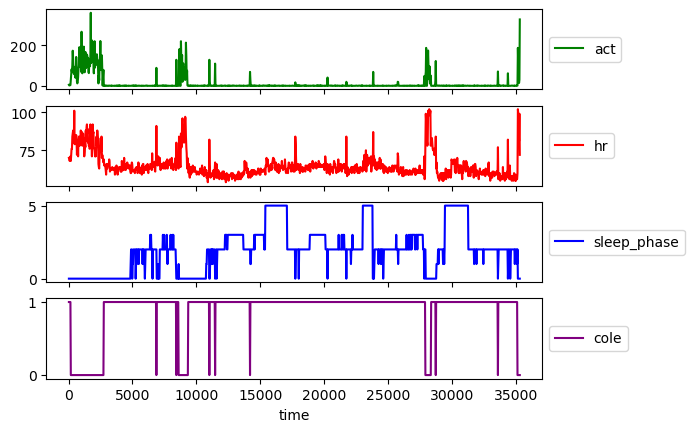

In [10]:
data_exploration(df[df["pid"] == 20])

# Result Evaluation

In [11]:
from sklearn import metrics
metrics.accuracy_score(df["sleep_phase"] > 0, df["cole"])

0.7869899571257741